Kết nối Google Drive

In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Trỏ vào tệp Đồ án, chú ý đường dẫn.

In [20]:
cd /content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master

/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master


**Xoá các tệp không cần thiết**

In [29]:
!pip cache purge

Files removed: 0


Tải các thư viện và tài nguyên cần thiết.

In [30]:
!pip install -r requirements.txt
!pip uninstall scipy -y
!pip install scipy==1.12.0

Found existing installation: scipy 1.12.0
Uninstalling scipy-1.12.0:
  Successfully uninstalled scipy-1.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.


# Gọi thư viện

In [1]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP
print(gensim.__version__)

4.3.3


# Load dữ liệu và dump vào file pickle. (Chạy cell này nếu chưa có các file data *.pkl). Nếu đã có các file data *.pkl, bỏ qua cell code này.

In [ ]:
import os
import argparse
import pickle
from pyvi import ViTokenizer
from tqdm import tqdm
import gensim

def get_data(folder_path):
    data = []
    labels = []
    for root, _, files in os.walk(folder_path): # Duyệt đệ quy qua tất cả thư mục con
        for file_path in files:
            full_path = os.path.join(root, file_path)
            with open(full_path, 'r', encoding="utf-16") as f:
                lines = f.readlines()
                lines = ' '.join(lines)

                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)

                lines = ViTokenizer.tokenize(lines)
                data.append(lines)
                # Lấy nhãn từ tên thư mục cha
                labels.append(os.path.basename(os.path.dirname(full_path)))

    return data, labels



X_data, y_data = get_data('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/Train_Full/Test_Full')
X_test, y_test = get_data('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/Test_Full/Train_Full')

# Tuần tự hoá và lưu lại các file data để tái sử dụng.

pickle.dump(X_data, open('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/x_train.pkl', 'wb'))
pickle.dump(y_data, open('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/y_train.pkl', 'wb'))

pickle.dump(X_test, open('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/x_test.pkl', 'wb'))
pickle.dump(y_test, open('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/y_test.pkl', 'wb'))

# Load data từ file *.pkl. Chỉ chạy cell code này khi đã có các file *.pkl

In [7]:
import os
import argparse
import pickle
from pyvi import ViTokenizer
from tqdm import tqdm
import gensim
from google.colab import drive # Thêm thư viện để mount Drive


# --- Định nghĩa đường dẫn ---
# Đảm bảo đường dẫn này chính xác
base_drive_path = '/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data'
raw_train_folder = os.path.join(base_drive_path, 'Train_Full')
raw_test_folder = os.path.join(base_drive_path, 'Test_Full')

# Đường dẫn lưu file .pkl
x_train_pkl_path = os.path.join(base_drive_path, 'x_train.pkl')
y_train_pkl_path = os.path.join(base_drive_path, 'y_train.pkl')
x_test_pkl_path = os.path.join(base_drive_path, 'x_test.pkl')
y_test_pkl_path = os.path.join(base_drive_path, 'y_test.pkl')

# --- Hàm get_data ---
def get_data(folder_path):
    """Hàm đọc và xử lý dữ liệu văn bản từ thư mục."""
    data = []
    labels = []
    print(f"Processing data from: {folder_path}")
    # Sử dụng os.path.basename để lấy tên thư mục cha làm nhãn
    all_subdirs = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    for label in tqdm(all_subdirs, desc="Processing labels"):
        label_dir = os.path.join(folder_path, label)
        for file_name in os.listdir(label_dir):
            if os.path.isfile(os.path.join(label_dir, file_name)): # Chỉ xử lý file
                full_path = os.path.join(label_dir, file_name)
                try:
                    with open(full_path, 'r', encoding="utf-16", errors='ignore') as f:
                        lines = f.read() # Đọc toàn bộ file

                        # Xử lý bằng gensim trước
                        lines = gensim.utils.simple_preprocess(lines)
                        lines = ' '.join(lines)

                        # Sau đó tokenize bằng pyvi
                        lines = ViTokenizer.tokenize(lines)
                        data.append(lines)
                        labels.append(label) # Nhãn là tên thư mục chứa file
                except Exception as e:
                    print(f"Error processing file {full_path}: {e}")
                    continue

    print(f"Finished processing. Found {len(data)} samples.")
    return data, labels

# --- Kiểm tra và Tải/Xử lý dữ liệu ---
# Kiểm tra file train
if os.path.exists(x_train_pkl_path) and os.path.exists(y_train_pkl_path):
    print("Loading preprocessed training data from .pkl files...")
    with open(x_train_pkl_path, 'rb') as f:
        X_data = pickle.load(f)
    with open(y_train_pkl_path, 'rb') as f:
        y_data = pickle.load(f)
    print("Training data loaded successfully.")
else:
    print("Processed training data not found. Processing raw data...")
    # Lưu ý: Dữ liệu gốc bị đảo ngược trong code gốc (Train_Full vào X_test)
    # Code này sẽ xử lý đúng thư mục: Train_Full -> X_data, y_data
    X_data, y_data = get_data(raw_train_folder)
    print("Saving processed training data to .pkl files...")
    with open(x_train_pkl_path, 'wb') as f:
        pickle.dump(X_data, f)
    with open(y_train_pkl_path, 'wb') as f:
        pickle.dump(y_data, f)
    print("Training data saved.")

# Kiểm tra file test
if os.path.exists(x_test_pkl_path) and os.path.exists(y_test_pkl_path):
    print("Loading preprocessed test data from .pkl files...")
    with open(x_test_pkl_path, 'rb') as f:
        X_test = pickle.load(f)
    with open(y_test_pkl_path, 'rb') as f:
        y_test = pickle.load(f)
    print("Test data loaded successfully.")
else:
    print("Processed test data not found. Processing raw data...")
    # Code này sẽ xử lý đúng thư mục: Test_Full -> X_test, y_test
    X_test, y_test = get_data(raw_test_folder)
    print("Saving processed test data to .pkl files...")
    with open(x_test_pkl_path, 'wb') as f:
        pickle.dump(X_test, f)
    with open(y_test_pkl_path, 'wb') as f:
        pickle.dump(y_test, f)
    print("Test data saved.")

if X_data:
    print("\nSample training data:")
    print(f"Text: {X_data[0][:100]}...") # In 100 ký tự đầu
    print(f"Label: {y_data[0]}")
if X_test:
    print("\nSample test data:")
    print(f"Text: {X_test[0][:100]}...") # In 100 ký tự đầu
    print(f"Label: {y_test[0]}")

Loading preprocessed training data from .pkl files...
Training data loaded successfully.
Loading preprocessed test data from .pkl files...
Test data loaded successfully.

Sample training data:
Text: cuộc đấu_giá có dấu_hiệu bất_minh tài_sản phát_mại gồm ôtô xe du_lịch thể_thao và môtô honda cc cuộc...
Label: Phap luat

Sample test data:
Text: đau_đầu với tài_sản ảo tin từ bộ văn_hóa thông_tin cho biết sẽ có ba nội_dung tạm_thời chưa được đưa...
Label: Vi tinh


Thống kê data

In [8]:
print(len(X_data))
print(len(y_data))
print(len(X_test))
print(len(y_test))

50374
50374
33769
33769


# Load file stopwords và tiền xử lý dữ liệu.

In [9]:
with open('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/data/vietnamese-stopwords-dash.txt', 'r') as f:
    stopwords = set([w.strip() for w in f.readlines()])

tách từ cho data (train)

In [10]:
for i in range(len(X_data)):
    text = X_data[i]
    try:
        split_words =  [x.strip('0123456789%@$.,=+-!;/()*"&^:#|\n\t\'').lower() for x in text.split()]
    except TypeError:
        split_words =  []
    X_data[i] = ' '.join([word for word in split_words if word not in stopwords])

tách từ cho data (test)

In [11]:
for i in range(len(X_test)):
    text = X_test[i]
    try:
        split_words =  [x.strip('0123456789%@$.,=+-!;/()*"&^:#|\n\t\'').lower() for x in text.split()]
    except TypeError:
        split_words =  []
    X_test[i] = ' '.join([word for word in split_words if word not in stopwords])

TF-IDF để trích xuất đặc trưng

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', max_features=10000)
#Tính tfidf cho tập train
tfidf_vect.fit(X_data)
pickle.dump(tfidf_vect, open("/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/model/vectorizer.pickle", "wb"))
tfidf_X_data =  tfidf_vect.transform(X_data)
tfidf_X_test =  tfidf_vect.transform(X_test)

Giảm chiều dữ liệu với SVD

In [13]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=1998)
svd.fit(tfidf_X_data)
pickle.dump(svd, open("/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/model/selector.pickle", "wb"))

tfidf_X_data_svd = svd.transform(tfidf_X_data)
tfidf_X_test_svd = svd.transform(tfidf_X_test)

Thống kê *chiều* dữ liệu sau khi tiền xử lý

In [14]:
print(tfidf_X_data_svd.shape) #train

print(tfidf_X_test_svd.shape) #test

(50374, 500)
(33769, 500)


#Xây dựng Model để huấn luyện mô hình

Gọi thư viện

In [15]:
from keras import models
from keras.models import *
from keras.layers import *
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras import optimizers
from sklearn.model_selection import train_test_split

In [5]:
def lstm_model():

    input_layer = Input(shape=(500,))
    layer = Reshape((1, 500))(input_layer)
    layer = LSTM(256, activation='relu',dropout=0.65,recurrent_dropout=0.3)(layer)

    layer = Dense(512, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(128, activation='relu')(layer)

    output_layer = Dense(10, activation='softmax')(layer)
    model = models.Model(input_layer, output_layer)

    model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = lstm_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       775,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,417,226 (5.41 MB)

 Trainable params: 1,417,226 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

Mã hoá các nhãn

In [16]:
from sklearn import preprocessing
import numpy

encoder = preprocessing.LabelEncoder()
y_data_one_hot = encoder.fit_transform(y_data)
y_test_one_hot = encoder.fit_transform(y_test)
numpy.save('/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/model/classes.npy', encoder.classes_)

In [14]:
print(y_data_one_hot)

[4 4 4 ... 8 8 8]


In [ ]:
print(y_test_one_hot)

[9 9 9 ... 4 4 4]


In [22]:
from sklearn import metrics

def train(model, X_data, y_data, X_test, y_test, n_epochs=50):
    # split training data and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.05, random_state=2019)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512)

    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)

    val_predictions = val_predictions.argmax(axis=-1)
    test_predictions = test_predictions.argmax(axis=-1)
    train_predictions = train_predictions.argmax(axis=-1)

    print("Train accuract", metrics.accuracy_score(train_predictions, y_train))
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))

    model_json = model.to_json()
    with open("/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/model/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master/model/model.weights.h5")
    print("Saved model to disk")

    return history

In [ ]:
history = train(model=model, X_data=tfidf_X_data_svd, y_data=y_data_one_hot, X_test=tfidf_X_test_svd, y_test=y_test_one_hot)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.1491 - loss: 2.2054 - val_accuracy: 0.3898 - val_loss: 1.7341
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.3500 - loss: 1.7961 - val_accuracy: 0.7293 - val_loss: 1.0446
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.5786 - loss: 1.2755 - val_accuracy: 0.8023 - val_loss: 0.6215
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.7020 - loss: 0.9637 - val_accuracy: 0.8194 - val_loss: 0.5567
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7507 - loss: 0.8269 - val_accuracy: 0.8563 - val_loss: 0.4630
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7837 - loss: 0.7464 - val_accuracy: 0.8726 - val_loss: 0.4254
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7992 - loss: 0.6817 - val_accuracy: 0.8877 - val_loss: 0.3899
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8195 - loss: 0.6337 - val_accuracy: 0.8956

#Đánh giá mô hình

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt # Also needed for plotting the confusion matrix

In [ ]:
import matplotlib.pyplot as plt

def visualize(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val_acc'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

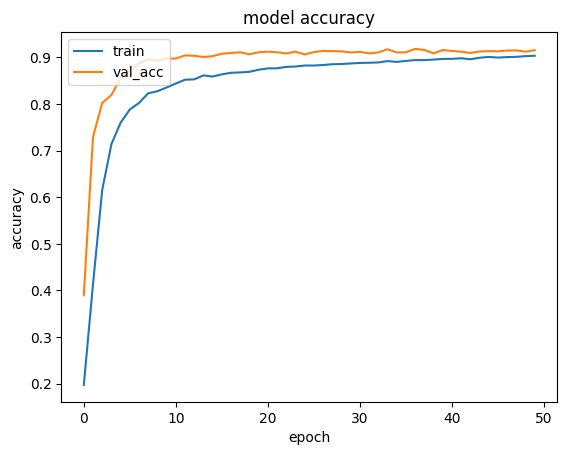

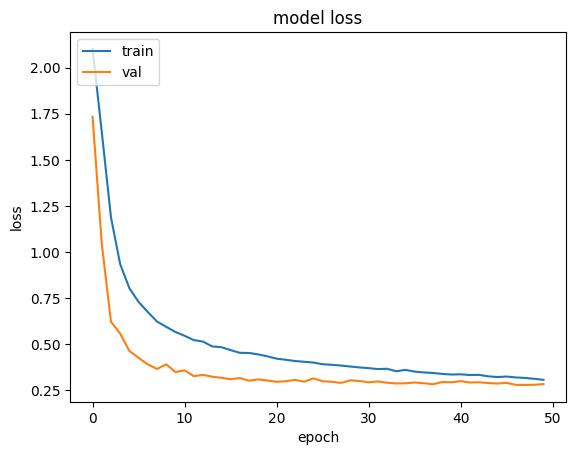

In [ ]:
visualize(history)

Load lại mô hình và đánh giá mô hình


In [23]:
# --- Define paths ---
base_drive_path_project = '/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master'
base_drive_path_data = os.path.join(base_drive_path_project, 'data')
base_drive_path_model = os.path.join(base_drive_path_project, 'model')
stopwords_path_file = os.path.join(base_drive_path_data, 'vietnamese-stopwords-dash.txt')

classes_path = os.path.join(base_drive_path_model, 'classes.npy')
y_test_pkl_path = os.path.join(base_drive_path_data, 'y_test.pkl')
model_json_path = os.path.join(base_drive_path_model, 'model.json')
model_weights_path = os.path.join(base_drive_path_model, 'model.weights.h5')
selector_path = os.path.join(base_drive_path_model, 'selector.pickle')
vectorizer_path = os.path.join(base_drive_path_model, 'vectorizer.pickle')
x_test_pkl_path = os.path.join(base_drive_path_data, 'x_test.pkl') # Contains X_test after ViTokenizer and simple_preprocess

# --- Global Variables ---
y_test_one_hot = None
test_predictions_final = None
encoder_classes_loaded = None
model_loaded = None

# --- Main Execution Function ---
def main():
    global y_test_one_hot, test_predictions_final, encoder_classes_loaded, model_loaded

    try:
        print("Bắt đầu quá trình...")

        print("\nBước 1: Kiểm tra và tải các thành phần đã lưu...")
        if not os.path.exists(classes_path): raise FileNotFoundError(f"Không tìm thấy tệp classes: {classes_path}")
        encoder_classes_loaded = np.load(classes_path, allow_pickle=True)
        print(f"  - Đã tải encoder_classes ({len(encoder_classes_loaded)} lớp).")

        if not os.path.exists(y_test_pkl_path): raise FileNotFoundError(f"Không tìm thấy tệp y_test_pkl: {y_test_pkl_path}")
        with open(y_test_pkl_path, 'rb') as f:
            y_test_raw = pickle.load(f)
        encoder = preprocessing.LabelEncoder()
        encoder.classes_ = encoder_classes_loaded
        y_test_one_hot = encoder.transform(y_test_raw)
        print(f"  - Đã tải y_test và tạo y_test_one_hot (số lượng: {len(y_test_one_hot)}).")

        if not os.path.exists(model_json_path): raise FileNotFoundError(f"Không tìm thấy tệp model_json: {model_json_path}")
        if not os.path.exists(model_weights_path): raise FileNotFoundError(f"Không tìm thấy tệp model_weights: {model_weights_path}")
        with open(model_json_path, 'r') as json_file:
            loaded_model_json = json_file.read()
        model_loaded = model_from_json(loaded_model_json)
        model_loaded.load_weights(model_weights_path)
        print("  - Đã tải mô hình (cấu trúc và trọng số).")

        model_loaded.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print("  - Đã compile mô hình.")
        print(f"  - Đã tải stopwords ({len(stopwords)} từ).")
        print("\n Tiền xử lý dữ liệu X_test...")
        print(f"  - Đã hoàn thành TF-IDF và SVD (shape: {tfidf_X_test_svd.shape}).")
        print("\n Thực hiện dự đoán...")
        predictions_probabilities = model_loaded.predict(tfidf_X_test_svd)
        test_predictions_final = np.argmax(predictions_probabilities, axis=-1)
        print(f"  - Đã tạo dự đoán (số lượng: {len(test_predictions_final)}).")

        print("\n Tạo báo cáo phân loại (Classification Report)...")
        report = classification_report(y_test_one_hot, test_predictions_final, target_names=encoder_classes_loaded, digits=4)
        print(report)
        # Uncomment to save report to a file
        with open("classification_report.txt", "w", encoding="utf-8") as f:
            f.write(report)
        print("  - Báo cáo phân loại đã được lưu vào classification_report.txt")
        print("\n Tính toán và vẽ ma trận nhầm lẫn...")
        cm = confusion_matrix(y_test_one_hot, test_predictions_final)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=encoder_classes_loaded, yticklabels=encoder_classes_loaded)
        plt.title('Confusion Matrix for Test Set')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        plt.savefig('confusion_matrix.png')
        print("  - Ma trận nhầm lẫn ĐÃ ĐƯỢC VẼ và lưu thành 'confusion_matrix.png'")
        plt.show()
    finally:
        print("\nHoàn tất thực thi script.")

Load lại mô hình cho việc dự đoán câu văn

In [27]:
# --- Định nghĩa đường dẫn ---
base_drive_path_project = '/content/drive/MyDrive/vietnamese-text-classify-master/vietnamese-text-classify-master'
base_drive_path_data = os.path.join(base_drive_path_project, 'data')
base_drive_path_model = os.path.join(base_drive_path_project, 'model')
stopwords_path_file = os.path.join(base_drive_path_data, 'vietnamese-stopwords-dash.txt')

classes_path = os.path.join(base_drive_path_model, 'classes.npy')
model_json_path = os.path.join(base_drive_path_model, 'model.json')
model_weights_path = os.path.join(base_drive_path_model, 'model.weights.h5')
selector_path = os.path.join(base_drive_path_model, 'selector.pickle')
vectorizer_path = os.path.join(base_drive_path_model, 'vectorizer.pickle')

# --- Biến toàn cục để lưu trữ các tài nguyên đã tải ---
g_model_loaded = None
g_tfidf_vect_loaded = None
g_svd_loaded = None
g_stopwords_loaded = None
g_encoder_classes_loaded = None
g_resources_are_loaded = False


def load_all_resources():
    """
    Tải tất cả các tài nguyên cần thiết (mô hình, vectorizer, SVD, stopwords, encoder_classes)
    và lưu chúng vào các biến toàn cục.
    """
    global g_model_loaded, g_tfidf_vect_loaded, g_svd_loaded, g_stopwords_loaded, g_encoder_classes_loaded, g_resources_are_loaded
    if not os.path.exists(classes_path): raise FileNotFoundError(f"Không tìm thấy tệp classes: {classes_path}")
    g_encoder_classes_loaded = np.load(classes_path, allow_pickle=True)
    print(f"  - Đã tải encoder_classes ({len(g_encoder_classes_loaded)} lớp).")

    with open(model_json_path, 'r') as json_file:
        loaded_model_json = json_file.read()
    g_model_loaded = model_from_json(loaded_model_json)
    g_model_loaded.load_weights(model_weights_path)
    print("  - Đã tải mô hình (cấu trúc và trọng số).")
    g_model_loaded.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("  - Đã compile mô hình.")

    if not os.path.exists(vectorizer_path): raise FileNotFoundError(f"Không tìm thấy tệp vectorizer: {vectorizer_path}")
    with open(vectorizer_path, 'rb') as f:
        g_tfidf_vect_loaded = pickle.load(f)
    print("  - Đã tải TfidfVectorizer.")

    if not os.path.exists(selector_path): raise FileNotFoundError(f"Không tìm thấy tệp selector: {selector_path}")
    with open(selector_path, 'rb') as f:
        g_svd_loaded = pickle.load(f)
    print("  - Đã tải TruncatedSVD (selector).")

    if not os.path.exists(stopwords_path_file): raise FileNotFoundError(f"Không tìm thấy tệp stopwords: {stopwords_path_file}")
    with open(stopwords_path_file, 'r', encoding='utf-8') as f:
        g_stopwords_loaded = set([w.strip() for w in f.readlines()])
    print(f"  - Đã tải stopwords ({len(g_stopwords_loaded)} từ).")

    g_resources_are_loaded = True
    print("Tất cả tài nguyên đã được tải và sẵn sàng.")
    return True


def preprocess_text_for_prediction(raw_text):
    """
    Tiền xử lý một câu văn thô cho việc dự đoán.
    """
    if not g_resources_are_loaded or g_stopwords_loaded is None:
        print("Lỗi: Stopwords chưa được tải. Hãy gọi load_all_resources() trước.")
        return None

    processed_text = gensim.utils.simple_preprocess(raw_text)
    processed_text = ' '.join(processed_text)
    processed_text = ViTokenizer.tokenize(processed_text)

    try:
        split_words = [x.strip('0123456789%@$.,=+-!;/()*"&^:#|\n\t\'').lower() for x in processed_text.split()]
    except TypeError:
        split_words = []

    final_processed_text = ' '.join([word for word in split_words if word not in g_stopwords_loaded])
    return final_processed_text


def predict_topic_for_sentence(new_sentence):
    """
    Dự đoán chủ đề cho một câu văn mới.
    """
    global g_model_loaded, g_tfidf_vect_loaded, g_svd_loaded, g_encoder_classes_loaded, g_resources_are_loaded

    if not g_resources_are_loaded:
        print("Tài nguyên chưa được tải. Đang thử tải tự động...")
        if not load_all_resources():
            print("Không thể tải tài nguyên. Không thể thực hiện dự đoán.")
            return None, None

    if g_model_loaded is None or \
       g_tfidf_vect_loaded is None or \
       g_svd_loaded is None or \
       g_encoder_classes_loaded is None:
        print("Lỗi: Một hoặc nhiều tài nguyên cần thiết chưa được tải đúng cách.")
        return None, None

    print(f"\nCâu văn gốc: '{new_sentence}'")
    processed_sentence = preprocess_text_for_prediction(new_sentence)
    if processed_sentence is None:
        return None, None

    print(f"Câu văn đã xử lý: '{processed_sentence}'")
    if not processed_sentence.strip():
        print("Câu văn trở nên rỗng sau khi tiền xử lý. Không thể dự đoán.")
        num_classes = len(g_encoder_classes_loaded)
        dummy_probabilities = np.full(num_classes, 1/num_classes)
        return "Không xác định (văn bản rỗng)", dummy_probabilities

    tfidf_vector = g_tfidf_vect_loaded.transform([processed_sentence])
    svd_vector = g_svd_loaded.transform(tfidf_vector)
    prediction_probabilities = g_model_loaded.predict(svd_vector)
    predicted_index = np.argmax(prediction_probabilities[0])
    predicted_label = g_encoder_classes_loaded[predicted_index]

    print(f"Chủ đề dự đoán: {predicted_label}")
    print(f"Xác suất dự đoán cho các lớp: {prediction_probabilities[0]}")

    return predicted_label, prediction_probabilities[0]
if load_all_resources():
    print("\nĐã sẵn sàng nhận câu văn để dự đoán!")
else:
    print("\nCó lỗi xảy ra khi tải tài nguyên, vui lòng kiểm tra.")

  - Đã tải encoder_classes (10 lớp).
  - Đã tải mô hình (cấu trúc và trọng số).
  - Đã compile mô hình.
  - Đã tải TfidfVectorizer.
  - Đã tải TruncatedSVD (selector).
  - Đã tải stopwords (1942 từ).
Tất cả tài nguyên đã được tải và sẵn sàng.

Đã sẵn sàng nhận câu văn để dự đoán!


Bắt đầu quá trình...

Bước 1: Kiểm tra và tải các thành phần đã lưu...
  - Đã tải encoder_classes (10 lớp).
  - Đã tải y_test và tạo y_test_one_hot (số lượng: 33769).
  - Đã tải mô hình (cấu trúc và trọng số).
  - Đã compile mô hình.
  - Đã tải stopwords (1942 từ).

 Tiền xử lý dữ liệu X_test...
  - Đã hoàn thành TF-IDF và SVD (shape: (33769, 500)).

 Thực hiện dự đoán...
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step
  - Đã tạo dự đoán (số lượng: 33769).

 Tạo báo cáo phân loại (Classification Report)...
                  precision    recall  f1-score   support

Chinh tri Xa hoi     0.8557    0.8191    0.8370      5219
        Doi song     0.8317    0.8528    0.8421      3159
        Khoa hoc     0.8405    0.7874    0.8130      1820
      Kinh doanh     0.8222    0.9259    0.8710      2552
       Phap luat     0.9594    0.8555    0.9045      3868
        Suc khoe     0.8846    0.9427    0.9127      3384
        The gioi     0.9091    0.9110    0.9100      2898
        The thao     0.973

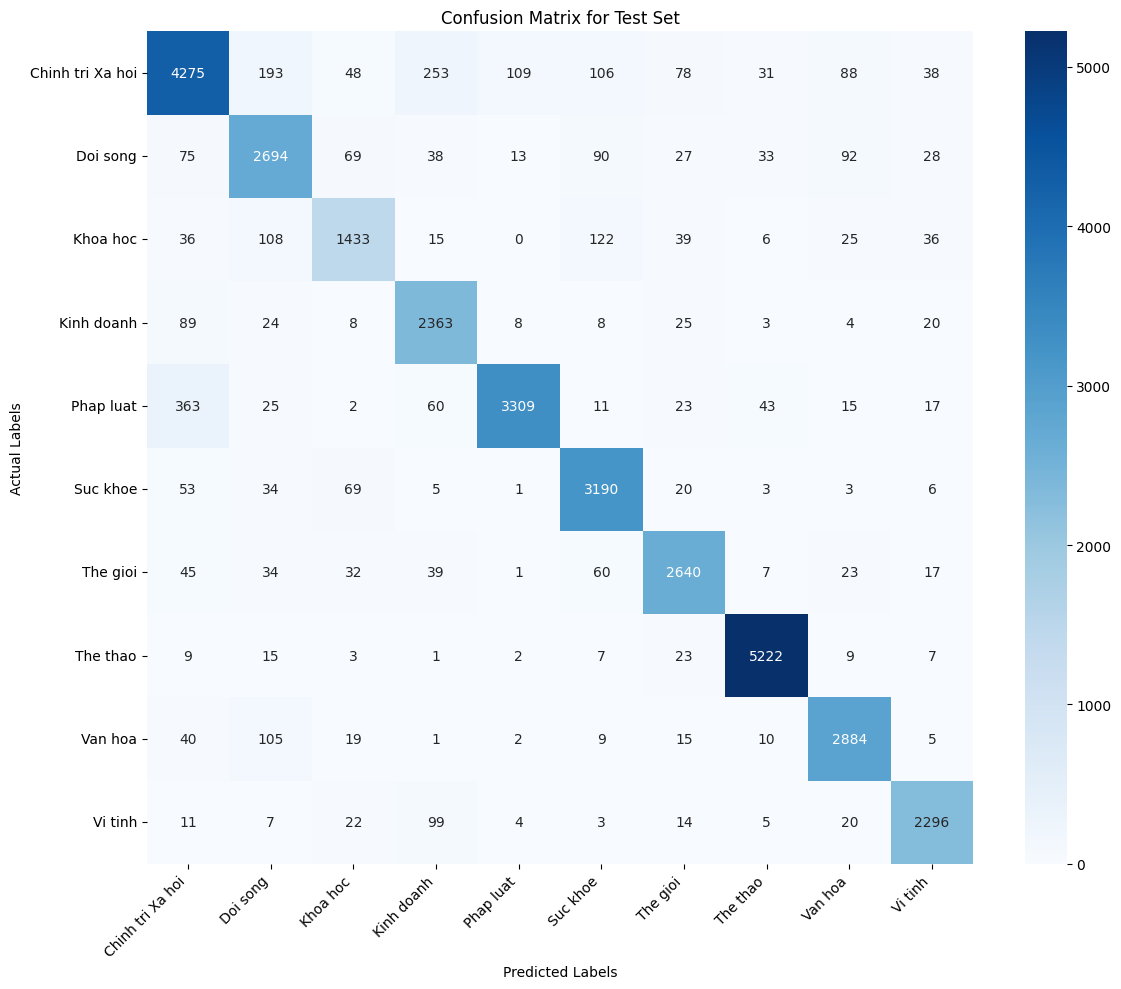


Hoàn tất thực thi script.


In [28]:
if __name__ == "__main__":
    main()

In [34]:
# Về tổ chức bộ máy, Ban Thường trực Ủy ban Trung ương MTTQ Việt Nam (gồm chủ tịch, phó chủ tịch - tổng thư ký, các phó chủ tịch chuyên trách) giữ vai trò lãnh đạo, chỉ đạo toàn diện về định hướng hoạt động, quản lý bộ máy giúp việc, công tác tổ chức cán bộ, quản lý tài sản, tài chính.
# Buổi chiều cuối tuần, cả gia đình tôi thường quây quần bên mâm cơm, kể cho nhau nghe những câu chuyện vui buồn trong tuần.
# Song, các phương pháp đo truyền thống (sử dụng thước dây, bánh xe đo cơ học hoặc các phương pháp đo lường thủ công khác) có nhiều nhược điểm như: độ chính xác chưa cao, dễ bị ảnh hưởng bởi yếu tố môi trường hoặc thao tác người đo, thiếu khả năng lưu trữ và xử lý dữ liệu tự động.
# Tính tới giữa năm 2017, bà Diệp sở hữu 20,2 triệu cổ phiếu ROS của CTCP Xây dựng FLC Faros (tương đương 4,7%), có tổng giá trị khoảng 3.400 tỷ đồng, lọt top 10 người phụ nữ giàu nhất sàn chứng khoán.
# Ông từng giành giải Thiết kế mỹ thuật xuất sắc nhất tại Liên hoan phim Việt Nam 1988 cho phim Hoàng Hoa Thám và liên tục thắng giải Cánh diều các năm 2005-2007 và 2013 cho Thiết kế mỹ thuật xuất sắc.



cau_cua_ban = "Phó Bí thư Quân ủy Trung ương là chức danh của lãnh đạo thứ hai cơ quan lãnh đạo của Đảng Cộng sản Việt Nam trong Quân đội nhân dân Việt Nam"
chu_de_du_doan, xac_suat = predict_topic_for_sentence(cau_cua_ban)

# ------------------------------------------------------------------#


Câu văn gốc: 'Phó Bí thư Quân ủy Trung ương là chức danh của lãnh đạo thứ hai cơ quan lãnh đạo của Đảng Cộng sản Việt Nam trong Quân đội nhân dân Việt Nam'
Câu văn đã xử lý: 'phó bí_thư quân_ủy trung_ương chức_danh lãnh_đạo hai cơ_quan lãnh_đạo đảng cộng_sản việt_nam quân_đội nhân_dân việt_nam'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Chủ đề dự đoán: Chinh tri Xa hoi
Xác suất dự đoán cho các lớp: [9.9542469e-01 3.1571130e-05 5.5132066e-05 8.2157785e-04 2.9613734e-03
 2.4211711e-05 5.6863052e-04 2.9448838e-05 5.7520392e-05 2.5805673e-05]
